In [130]:
import numpy as np
import pandas as pd
from gensim.models import LdaMulticore
from helper_data import *
from helper_preprocess import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [181]:
# Load data
walks_folder = 'data/P3'
walk_path = 'all_p3'
#data = load_all_walks_comments(walks_folder, True)
data = load_all_walks_tags(walks_folder, True)

In [182]:
data.shape

(1938, 12)

In [183]:
data.loc[data['video_duration'] == 'None'].shape

(1678, 12)

In [184]:
# Drop the videos where nan occurs
data = data.dropna(subset='keywords')
tags = data['keywords'].tolist()
walks_id = data['walk'].tolist()

In [185]:
len(tags)

1781

In [186]:
# To remove afterwards
data = data[data['video_duration'] != 'None']

## Preprocessing

In [188]:
# Preprocess the data
tags_prep = [preprocess(t, tag=True) for t in tags]

In [189]:
# Filter out words that appear in more than 30% of the videos and words that
# appear less than 3 times
min_words = 3
max_freq = 0.3

dictionary, corpus = create_corpus(tags_prep, min_words, max_freq)

In [190]:
len(corpus)

1781

## LDA

In [191]:
# LDA parameters
workers = 3
passes = 1000
random_state = 123
num_topics = 12
alpha = 0.05 # < 1 gives sparse topics distributions
eta = 0.05 # < 1 gives sparse words distribution inside each topic

lda_model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=workers, passes=passes, random_state=random_state, alpha=alpha, eta=eta)

In [192]:
lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

[(0,
  [('suit', 0.19535585),
   ('harvey', 0.07454445),
   ('mike', 0.04875112),
   ('ross', 0.043627605),
   ('season', 0.037255786),
   ('specter', 0.032819964),
   ('episode', 0.030537957),
   ('patrick', 0.02637159),
   ('road', 0.026181804),
   ('michael', 0.026057776)]),
 (1,
  [('minecraft', 0.08600539),
   ('sport', 0.038155783),
   ('tool', 0.028154686),
   ('level', 0.02690175),
   ('racing', 0.026481694),
   ('action', 0.026425477),
   ('invention', 0.026061606),
   ('prix', 0.024801673),
   ('grand', 0.024801673),
   ('another', 0.02270152)]),
 (2,
  [('cooking', 0.07300518),
   ('life', 0.03502634),
   ('become', 0.030952714),
   ('recipe', 0.02804725),
   ('lawyer', 0.027995886),
   ('chateau', 0.02711065),
   ('closing', 0.02212274),
   ('food', 0.018514039),
   ('cook', 0.017058559),
   ('country', 0.017052889)]),
 (3,
  [('sharpe', 0.10456389),
   ('history', 0.038201056),
   ('animal', 0.036272712),
   ('sharpes', 0.028393164),
   ('bean', 0.028393155),
   ('sean', 0

Tests made :
passes=10 for below
- alpha=0.5, eta=1, num_topics=10 :
    - Individual topics easily interpretable, but some are a bit mixed -> decrease alpha and maybe eta too, to get more polarized topics in each video and more specific vocabulary in each topic
    - Multiple topics about the same subject : especially music -> reduce number of topics
- alpha=0.2, eta=1, num_topics=10 :
    - More polarized topics as wanted
    - Still some mixed topics
    - Still multiple topics about the same subjects (especially music again)
- alpha=0.2, eta=1, num_topics=7 :
    - Fewer similar topics, but kind of more mixed words in each topic
- alpha=0.2, eta=0.8, num_topics=7 :
    - Still approx. 2 topics on music -> reduce num_topics
- alpha=0.2, eta=0.8, num_topics=6 :
    - More or less distinct topics
    - First 4 are easily interpretable but last 2 are more mixed (music-minecraft)
- alpha=0.2, eta=0.8, num_topics=5 :
    - Even more mixed up topics -> need more than 5 topics to fit well


passes=50 for below (training time is still very short)
- alpha=0.1, eta=0.7, num_topics=7 :
    - Still a bit mixed up topics in the last 2 -> might actually need to increase num_topics but set sharper alpha and eta
- alpha=0.1, eta=0.1, num_topics=8 :
    - Again the first few topics are very good but the last ones are more mixed up

Observation : might want to remove the word "official", appears often in the topics (e.g. for music, etc) but not really informative about the subject

passes=100 for below (training time is still very short)
- alpha=0.1, eta=0.1, num_topics=8 :
    - Similar to passes=50
- alpha=50/num_topics (typical value used in practice), eta=0.1, num_topics=8 :
    - Quite good topics but somewhat mixed -> try to lower the 50
- alpha=25/num_topics, eta=0.1, num_topics=8 :
    - Quite good topics
- alpha=25/num_topics, eta=0.1, num_topics=7 :
    - Quite good topics but a bit more mixed -> keep num_topics=8
- alpha=1, eta=0.1, num_topics=8 :
    - Quite good topics but got two music topics
- alpha=25/num_topics, eta=0.01, num_topics=8 :
    - Topics very similar to previous setup
    - Again 2 topics on music
- alpha=10/num_topics, eta=0.01, num_topics=8 :
    - Again very similar to previous setup
    - And again 2 topics on music
- alpha=0.99, eta=0.1, num_topics=15 :
    - Not so bad : many similar topics but more interpretable (less mixed)


In the end -> have to tune with final data

In [193]:
# Interpret the topics
topics_name = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
topic_id2name = {i: topics_name[i] for i in range(num_topics)}
topic_name2id = {v: k for k, v in topic_id2name.items()}

## Clustering the videos

In [194]:
# Build the "embeddings" for each document using its topics distribution
embeddings = np.zeros((len(corpus), num_topics))
for i, doc_bow in enumerate(corpus):
    topics_distr = lda_model.get_document_topics(doc_bow)
    embedding = [0.0] * num_topics

    for id, p in topics_distr:
        embedding[id] = p

    embeddings[i, :] = embedding

Eventually do a silouhette score to test what is the best number of topics.

In [195]:
from sklearn.manifold import TSNE

# Init pca is more stable,
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=random_state)
corpus_emb = tsne.fit_transform(embeddings)

/home/cpittet/anaconda3/envs/shs/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



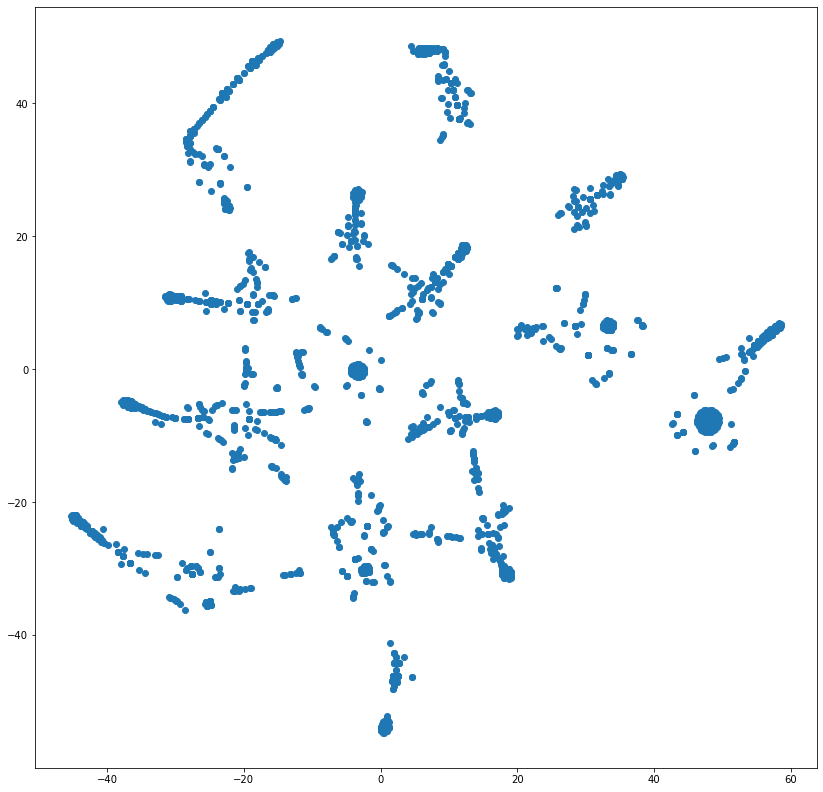

In [196]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,14)

plt.scatter(corpus_emb[:, 0], corpus_emb[:, 1])
plt.show()

In [197]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

from matplotlib.colors import rgb2hex
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

Loading BokehJS ...

In [198]:
xs, ys = corpus_emb[:, 0], corpus_emb[:, 1]
best_topic_ids = [np.argmax(row) for row in embeddings.tolist()]

# We will need to separate runs, here we have all runs of P3
colors = [val2rgb(i) for i in range(len(xs))]

In [199]:
# Use pandas and plotly instead
df = pd.DataFrame({'x': corpus_emb[:, 0], 'y': corpus_emb[:, 1], 'best_topic_id': best_topic_ids, 'walk_id': [str(i) for i in walks_id], 'color': colors})

In [200]:
import plotly.express as px

fig = px.scatter(df, x='x', y='y', color='walk_id', hover_data=['best_topic_id'], width=800, height=800)
fig.show()

Output df with all original columns, columns for the topics distribution, one column for the most important topic of the video, one column for the most attributed topic in the run of this video.

In [201]:
embeddings.shape

(1781, 12)

In [202]:
df_embeddings = pd.DataFrame(embeddings, columns=[f'topic_id_{i}' for i in range(embeddings.shape[1])])
df_embeddings['video_best_topic_id'] = df_embeddings.apply(lambda row: np.argmax(row), axis=1)
df_embeddings['video_best_topic'] = df_embeddings['video_best_topic_id'].apply(lambda id: topic_id2name[id])
df_output = pd.concat([data.reset_index(drop=True), df_embeddings], axis=1)

In [203]:
# Only keep the first topic if there are multiple modes for a walk
df_walk_best_topic = df_output[['walk', 'video_best_topic_id']].groupby('walk').agg(lambda  x: pd.Series.mode(x)[0]).rename(columns={'video_best_topic_id': 'walk_best_topic_id'})
df_walk_best_topic['walk_best_topic'] = df_walk_best_topic['walk_best_topic_id'].apply(lambda id: topic_id2name[id])
df_output = df_output.join(df_walk_best_topic, on='walk', how='left')

In [204]:
df_output.head()

,video_link,title,description,channel_link,channel_title,keywords,nb_like,nb_views,nb_sub,video_duration,...,topic_id_6,topic_id_7,topic_id_8,topic_id_9,topic_id_10,topic_id_11,video_best_topic_id,video_best_topic,walk_best_topic_id,walk_best_topic
0,https://www.youtube.com/watch?v=Vaz_kpmTi0M,"Hey Mama - David Guetta ft. Nicki Minaj, Bebe ...",Minny Park teaches choreography to Hey Mama by...,1MILLION Dance Studio,https://www.youtube.com/channel/UCw8ZhLPdQ0u_Y...,choreography hiphop,"1,542,688","118,020,394",25M,269,...,0.019231,0.019231,0.019231,0.019231,0.019231,0.019231,2,c,0.0,a
1,https://www.youtube.com/watch?v=Kl5B6MBAntI,NaN,ED SHEERAN - Shape Of You | Dance Choreography...,KYLE HANAGAMI,https://www.youtube.com/channel/UCGzGbfhdFsjP1...,ed sheeran Shape of you hip hop choreograph...,"2,022,904",None,4.54M,320,...,0.000000,0.000000,0.000000,0.000000,0.168608,0.000000,2,c,0.0,a
2,https://www.youtube.com/watch?v=0HKfjsM2hSw,#JusticeForMOMOLAND #MerriesStandWithDAISY Mom...,Daisy says ‘Finding Momoland’ survival show wa...,kurokuroku,https://www.youtube.com/channel/UCRUE1E1_DOnXN...,momoland comeback momoland new song momolan...,"588,633","227,955,367",None,212,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,c,0.0,a
3,https://www.youtube.com/watch?v=dhQtq9YxrGI,TAKI TAKI | @placedancers Choreography Julie B,NaN,PLACE,https://www.youtube.com/channel/UCo3BbgAZgkT7T...,choreography,"53,433","15,609,749",375K,403,...,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0,a,0.0,a
4,https://www.youtube.com/watch?v=tJ71PAN2HqM,Gangnam Style Flashmob at Square 2 (Singapore),NaN,-boo,https://www.youtube.com/channel/UCERPXBVs-78js...,New,"4,255","617,678",1.1K,238,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,a,0.0,a


# Visualizations + Basic statistics for website

In [205]:
df_output['x'] = corpus_emb[:, 0]
df_output['y'] = corpus_emb[:, 1]

In [206]:
all_topics = df_output['video_best_topic'].unique().tolist()

In [207]:
from matplotlib.colors import rgb2hex
cmap = plt.get_cmap('magma')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

def str2color(txt):
    return rgb2hex(cmap(topic_name2id[txt])[:3])

## Basic statistics

### Video duration through the runs

In [208]:
df_output.head()

,video_link,title,description,channel_link,channel_title,keywords,nb_like,nb_views,nb_sub,video_duration,...,topic_id_8,topic_id_9,topic_id_10,topic_id_11,video_best_topic_id,video_best_topic,walk_best_topic_id,walk_best_topic,x,y
0,https://www.youtube.com/watch?v=Vaz_kpmTi0M,"Hey Mama - David Guetta ft. Nicki Minaj, Bebe ...",Minny Park teaches choreography to Hey Mama by...,1MILLION Dance Studio,https://www.youtube.com/channel/UCw8ZhLPdQ0u_Y...,choreography hiphop,"1,542,688","118,020,394",25M,269,...,0.019231,0.019231,0.019231,0.019231,2,c,0.0,a,30.648417,25.540243
1,https://www.youtube.com/watch?v=Kl5B6MBAntI,NaN,ED SHEERAN - Shape Of You | Dance Choreography...,KYLE HANAGAMI,https://www.youtube.com/channel/UCGzGbfhdFsjP1...,ed sheeran Shape of you hip hop choreograph...,"2,022,904",None,4.54M,320,...,0.000000,0.000000,0.168608,0.000000,2,c,0.0,a,28.347929,25.317059
2,https://www.youtube.com/watch?v=0HKfjsM2hSw,#JusticeForMOMOLAND #MerriesStandWithDAISY Mom...,Daisy says ‘Finding Momoland’ survival show wa...,kurokuroku,https://www.youtube.com/channel/UCRUE1E1_DOnXN...,momoland comeback momoland new song momolan...,"588,633","227,955,367",None,212,...,0.000000,0.000000,0.000000,0.000000,2,c,0.0,a,34.150333,28.474987
3,https://www.youtube.com/watch?v=dhQtq9YxrGI,TAKI TAKI | @placedancers Choreography Julie B,NaN,PLACE,https://www.youtube.com/channel/UCo3BbgAZgkT7T...,choreography,"53,433","15,609,749",375K,403,...,0.083333,0.083333,0.083333,0.083333,0,a,0.0,a,-3.748405,-1.090515
4,https://www.youtube.com/watch?v=tJ71PAN2HqM,Gangnam Style Flashmob at Square 2 (Singapore),NaN,-boo,https://www.youtube.com/channel/UCERPXBVs-78js...,New,"4,255","617,678",1.1K,238,...,0.000000,0.000000,0.000000,0.000000,0,a,0.0,a,-20.711109,43.573616


In [209]:
df_output.groupby('walk').cumcount()

0          0
1          1
2          2
3          3
4          4
        ... 
1776    1535
1777    1536
1778    1537
1779    1538
1780    1539
Length: 1781, dtype: int64

In [215]:
fig = px.scatter(df_output, x=df_output.groupby('walk').cumcount(), y='video_duration',
              color=df_output['walk'].astype(str), title='Duration of videos across each run',
                 log_y=True,
                 labels={'video_duration': 'Video duration [s]', 'x': 'Position in the run'})

fig.show()

In [219]:
fig = px.box(df_output, x=df_output['walk'].astype(str), y='video_duration', log_y=True,
             title='Distribution of the duration of videos in each run',
             labels={'x': 'Runs', 'video_duration': 'Video duration [s]'})

fig.show()

### Video views through the runs

In [167]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1779 entries, 0 to 1778
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_link           1779 non-null   object 
 1   title                1715 non-null   object 
 2   description          1517 non-null   object 
 3   channel_link         1779 non-null   object 
 4   channel_title        1779 non-null   object 
 5   keywords             1779 non-null   object 
 6   nb_like              1779 non-null   object 
 7   nb_views             1779 non-null   object 
 8   nb_sub               1779 non-null   object 
 9   video_duration       1779 non-null   object 
 10  watch time           1779 non-null   object 
 11  walk                 1779 non-null   int64  
 12  topic_id_0           1779 non-null   float64
 13  topic_id_1           1779 non-null   float64
 14  topic_id_2           1779 non-null   float64
 15  topic_id_3           1779 non-null   f

In [220]:
fig = px.scatter(df_output, x=df_output.groupby('walk').cumcount(), y='nb_views',
                 color=df_output['walk'].astype(str), title='Number of views of videos across each run',
                 log_y=True,
                 labels={'nb_views': 'Number of views', 'x': 'Position in the run'})

fig.show()

In [221]:
fig = px.box(df_output, x=df_output['walk'].astype(str), y='nb_views', log_y=True,
             title='Distribution of the number of views of the videos in each run',
             labels={'x': 'Runs', 'nb_views': 'Number of views'})

fig.show()

#### Heatmap showing the tendencies of getting from a nb_view to another

## Color runs based on the most frequent topic in this run

In [128]:
import plotly.graph_objects as go

fig = px.scatter(df_output, x='x', y='y', color='walk_best_topic',
                 #hover_data=['walk_best_topic'], hover_name='video_best_topic',

                 width=800, height=800,
                 title='Runs colored by most frequent topic')

customdata = df_output[['video_best_topic', 'walk_best_topic', 'walk']]

fig = go.Figure(go.Scatter(
    x=df_output['x'], y=df_output['y'],
    customdata=customdata,
    marker=dict(color=df_output['walk_best_topic_id'], colorbar=dict(title='Run topics')),
    mode='markers', name='',
    hovertemplate=
    '<br>Video topic : %{customdata[0]}</b><br>Run topic : %{customdata[1]}</b><br>Run id : %{customdata[2]}</br>'
))

fig.update_layout(
    width=1200,
    height=900,
    title='Runs colored by most frequent topic'
)
fig.show()